# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico IV : Aprendizaje no supervisado

**Antes de empezar:**
- [Instalar spaCy y el modelo de lenguaje con el que van a trabajar](https://spacy.io/models#quickstart)

**Consideraciones:**
- Se evalúa el estilo y prolijidad del código.
- Se permite hacer trabajo extra, siempre y cuando las actividades básicas estén resueltas.

**Recomendación:**
- Hay muchos ejemplos de código en internet, no se sientan obligados a implementar todo desde cero.
- La cantidad de líneas de código del esqueleto no es estricta, pueden completarlo con más (o menos) líneas.

### Librerías

In [6]:
!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install sklearn

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

In [31]:
import ast
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D




## Funciones Generales

In [8]:
def print_kmeans_inertia(df_skills, cluster_range=10):
    scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(cluster_range)]

    plt.plot(np.arange(2, cluster_range + 2), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel("Inertia")
    plt.title("Inertia of k-Means versus number of clusters")
    plt.show()
    
def get_df_songs(file_path = "./final_big.csv"):
    songs_base = pd.read_csv(file_path,sep="#")
    songs_base["genres"]=songs_base["genres"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
    songs_base["artists"]=songs_base["artists"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
    audio_thing= songs_base["audio_features"].apply(lambda x: ast.literal_eval(x))
    audio_features_base = pd.DataFrame(list(audio_thing))
    audio_features = audio_features_base.columns

    df_song_base = songs_base.reset_index(drop=True)
    audio_features_base = audio_features_base.reset_index(drop=True)
    df_song_base = pd.concat([df_song_base,audio_features_base],axis=1)
    return df_song_base

def scale_df_song(df, features_columns):
    df_features = df[features_columns]
    scaler = StandardScaler()
    df_scale = scaler.fit_transform(df_features)
    df_features_scale = pd.DataFrame(df_scale, columns=features_columns)
    return df_features, df_features_scale
    
def print_Silohuette(n_clusters, cluster_labels, df_skills, title):

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df_skills) + (n_clusters + 1) * 10])

    #cluster_labels = km.labels_

    silhouette_avg = silhouette_score(df_skills, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))    
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle((title),
                 fontsize=14, fontweight='bold')

    plt.show()

    

### Dependencias y acceso a APIs

In [10]:
'''import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch

client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

nlp = spacy.load("en_core_web_sm") # completar con el modelo que van a utilizar

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
musixmatch = Musixmatch('1aa5272f4402bf2f082ad2f3958c2c62') # se puede reemplazar por otra API si da mejores resultados
'''

'import pandas as pd\nimport numpy as np\nimport spotipy\nimport spacy\nfrom spotipy.oauth2 import SpotifyClientCredentials\nfrom musixmatch import Musixmatch\n\nclient_id = \'46b333d567314a89a6254b6c6b054be6\'\nclient_secret = \'9d922c3613e441518349dcf55f7d5853\'\nclient_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)\n\nnlp = spacy.load("en_core_web_sm") # completar con el modelo que van a utilizar\n\nsp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)\nmusixmatch = Musixmatch(\'1aa5272f4402bf2f082ad2f3958c2c62\') # se puede reemplazar por otra API si da mejores resultados\n'

### Funciones para gráficos
Estas funciones se utilizarán __sólo en el inciso 4)__

In [11]:
import matplotlib.pyplot as plt

def plot2D(title, X, colors):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=colors)
    plt.xlim(-50, 200)
    plt.ylim(-50, 170)
    ax.set_title(title)
    ax.set_xlabel('First component')
    ax.set_ylabel('Second Component')
    plt.colorbar(scatter);
    plt.plot()
    
def plot3D(title, X, colors):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors)
    plt.xlim(-50, 200)
    plt.ylim(-50, 170)
    ax.set_title(title)
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    ax.set_zlabel('Third component')
    plt.colorbar(scatter)

### 1) Recopilar los datos obtenidos en los prácticos anteriores

Para esta parte consideraremos [la playlist colaborativa de la mentoría](https://open.spotify.com/playlist/2IuD0qZb14cji5y52crdsO?si=nfHRPDquQRyotEcXc4tG7Q), de esta obtendremos:
- Las features del audio de las canciones
- Las features textuales de sus letras

Además es necesario aplicar el mismo preprocesamiento que aplicamos en los prácticos anteriores para ambos tipos de features (el preprocesamiento del p1 a las features de audio y el de p2 al de features textuales). En este caso la etiqueta no se utilizará para el proceso de clasificación dada la naturaleza no supervisada de nuestro clasificador.

Luego, se obtendrá como resultado el conjunto de variables X.

La última tarea de este inciso será aplicar escalado estándar a las features de X. La estandarización consiste en  reescalar las features de modo que estas tengan las propiedades de una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal) estándar (media = 0 y desviación estándar = 1). Esta tarea es [importante](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) en nuestro caso, ya que permite una mejor visualización de los clusters obtenidos por nuestro algoritmo.

**Recomendaciones:**
- Obtener las features por separado y hacer un join de los datasets.
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)
- Si usan features categóricas, ENCODEARLAS!

In [12]:
"""
Obtener features de audio
Obtener features de texto
Combinarlas en un DataFrame
"""

df_song_base = get_df_songs()
df_song_base.columns
features_columns = ['lyrics_sentiment', 'danceability', 'energy', 'key', 
                     'loudness', 'mode', 'speechiness', 'acousticness', 
                     'instrumentalness', 'liveness', 'valence', 'tempo']

df_features, df_features_scale = scale_df_song(df_song_base, features_columns)


X_unscaled = df_features
X_scaled = df_features_scale

### 2) Elegir un número óptimo de clusters

En este punto buscaremos el número de clusters que queremos para correr K-means obteniendo los mejores resultados. Para esto utilizaremos dos criterios de selección:
- Primero, el "método del codo" (Elbow method). Este es una técnica (heurística) muy popular en el aprendizaje no supervisado que consiste en correr el algoritmo con diferentes cantidades __k__ de clusters, calculando para cada caso la suma de distancias cuadradas de cada punto al centro asignado para su cluster (PISTA: estos valores se pueden obtener como un atributo del clasificador luego de ajustarlo a __X_scaled__). Luego graficamos para cada __k__ el valor obtenido, esto nos dará un gráfico con forma de brazo (curva) en el cual el codo del mismo (el punto de inflexión de la curva) es un buen valor para __k__.
- Segundo, el [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) nos da un coeficiente que va de -1 (peor) a 1 (mejor) y que nos dice qué tan similar es un punto a los demás dentro de su cluster y qué tan diferente es de los puntos en el resto de los clusters. En este caso nos quedaremos con el valor de k que maximice el Silhouette score para __X_scaled__.

La tarea consiste en obtener para cada caso el k que de mejores resultados de acuerdo a los gráficos obtenidos.

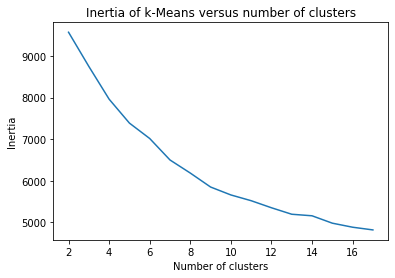

In [13]:
print_kmeans_inertia(X_scaled, cluster_range=16)

For n_clusters = 4 The average silhouette_score is : 0.13413146807236614


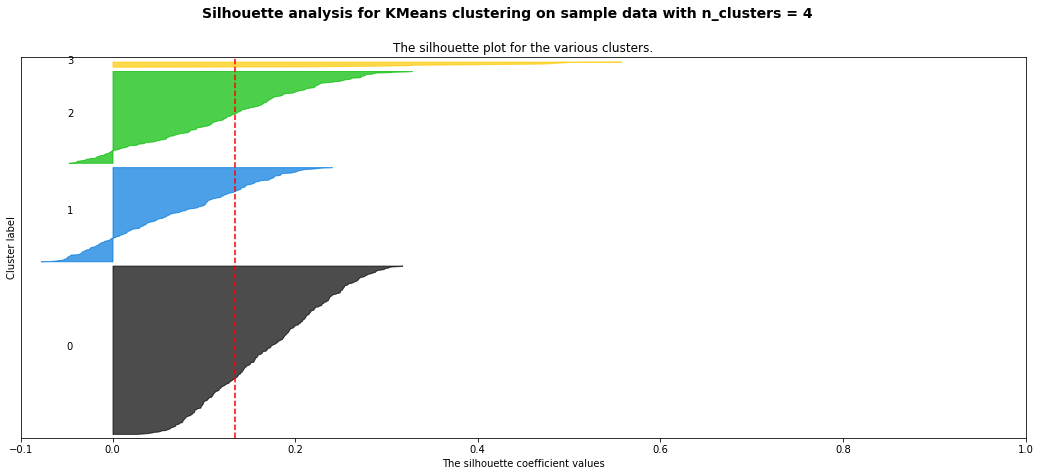

For n_clusters = 6 The average silhouette_score is : 0.13819261033199995


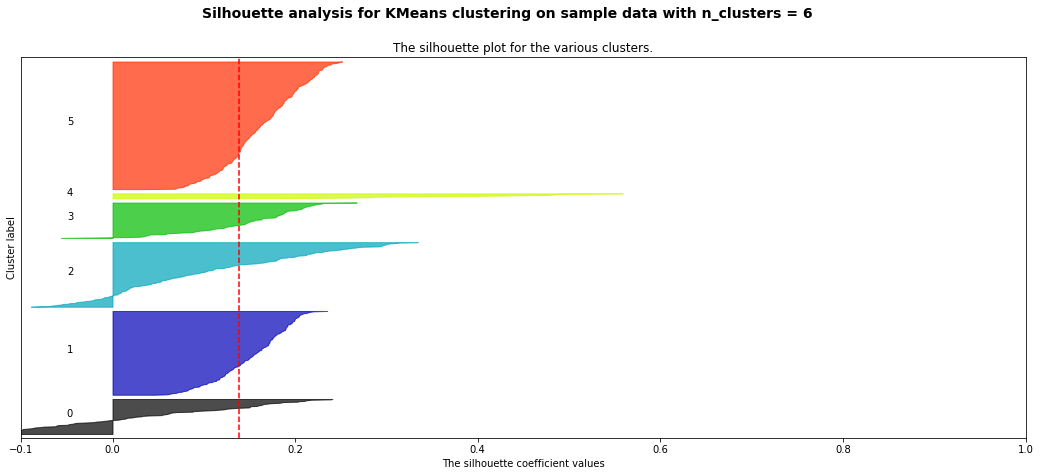

For n_clusters = 7 The average silhouette_score is : 0.13185394784978574


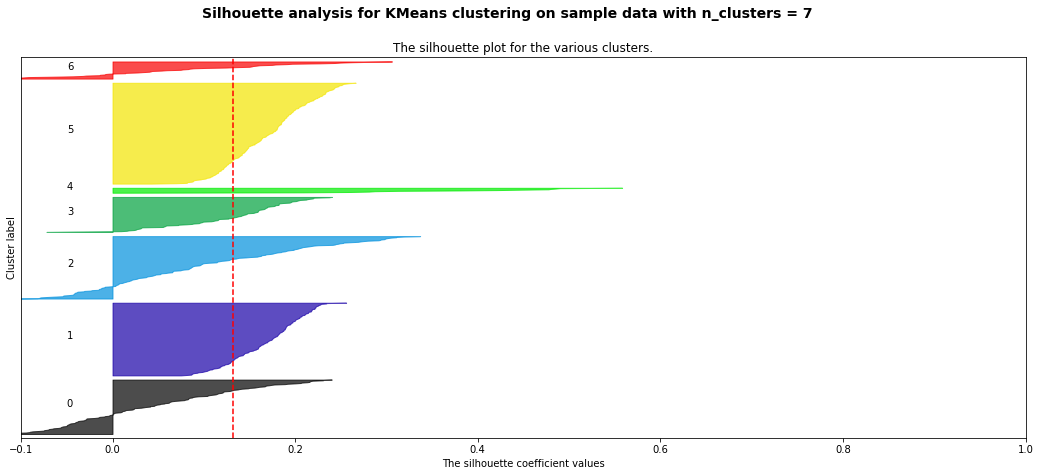

For n_clusters = 8 The average silhouette_score is : 0.13743350675838198


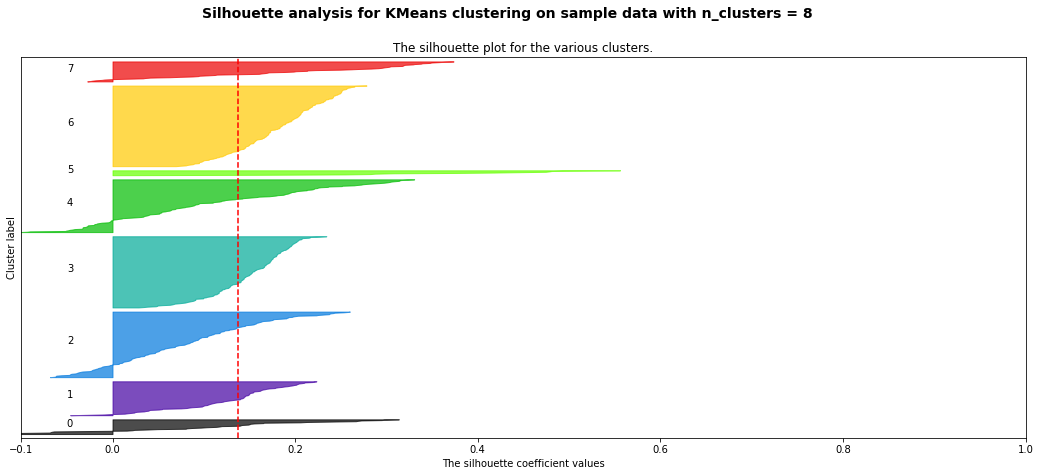

For n_clusters = 9 The average silhouette_score is : 0.13530150880851657


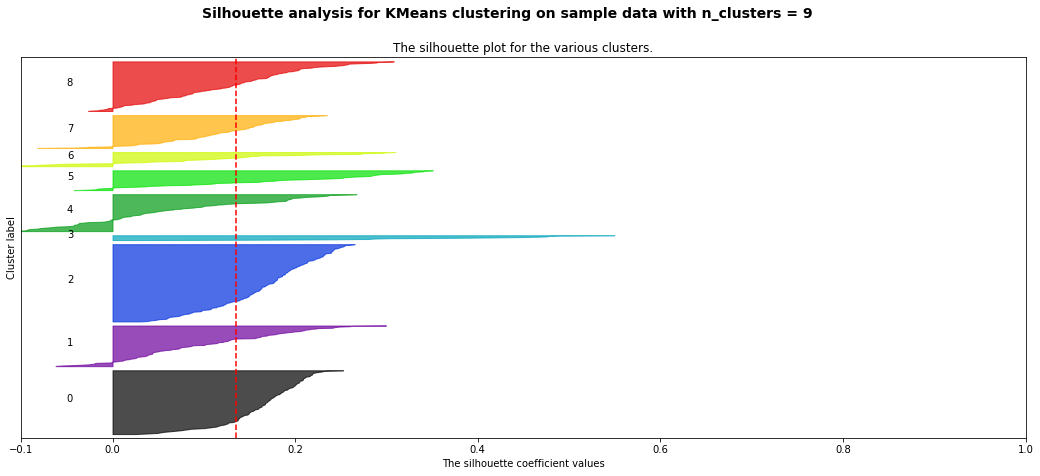

For n_clusters = 10 The average silhouette_score is : 0.12349126419681551


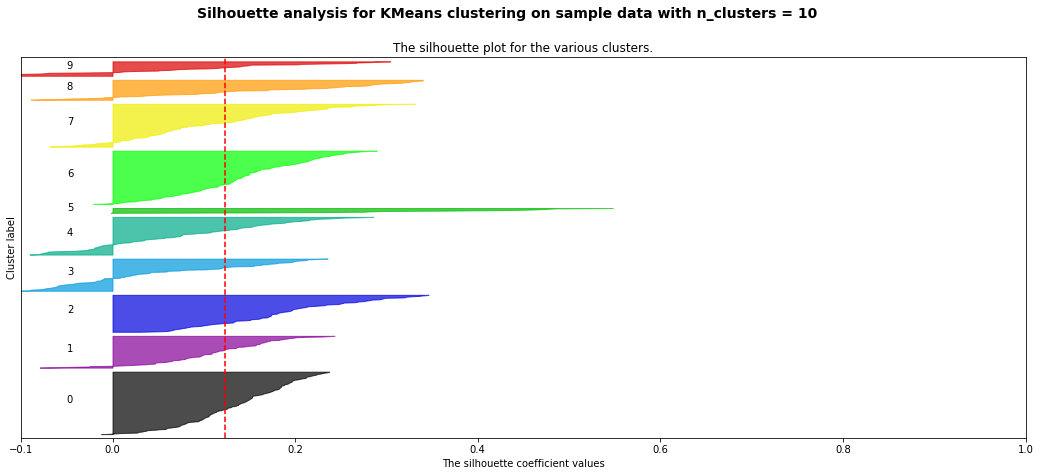

In [14]:
n_clusters_list = [4,6,7,8,9, 10]
for n in n_clusters_list:
    n_cluster_kmean =n
    km = KMeans(n_clusters=n_cluster_kmean, random_state=10)
    km.fit(X_scaled)
    title = "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_cluster_kmean
    print_Silohuette(n_cluster_kmean, km.labels_, X_scaled, title)



Los valores de k elegidos de acuerdo a estas dos reglas son:
- k1 = 4
- k2 = 8

### 3) Correr K-Means con los k elegidos

En este punto corremos de nuevo el algoritmo con los __k1__ y __k2__ elegidos en __2)__ y almacenaremos los resultados obtenidos en __X_preds_k1__ y __X_preds_k2__. Recuerden que el output de la predicción es un conjunto de __n__ (= #Canciones) etiquetas que nos dicen en qué cluster está cada canción __Xi__, por lo que deberán crear una tabla o mecanismo para obtener, además de las predicciones, los clusters como listas de canciones para cada __k__ elegido para su posterior análisis en el informe.

In [15]:
k1_nclusters = 4
k2_nclusters = 8
km_n_k1 = KMeans(n_clusters=k1_nclusters, random_state=10)
km_n_k2 = KMeans(n_clusters=k2_nclusters, random_state=10)

X_preds_k1 = km_n_k1.fit(X_scaled).labels_
X_preds_k2 = km_n_k2.fit(X_scaled).labels_

song_clusters_k1 = df_features_scale.copy()
song_clusters_k1['cluster'] = X_preds_k1

song_clusters_k2 = df_features_scale.copy()
song_clusters_k2['cluster'] = X_preds_k2

### 4) Graficar los clusters obtenidos

Para esta actividad utilizaremos las funciones __plot2D__ y __plot3D__ para graficar los clusters que obtuvimos en el ejercicio anterior. Previamente, se debe realizar una reducción de dimensiones al conjunto de datos __X_scaled__ para poder graficar los puntos dos y tres dimensiones, respectivamente. Por último, los colores de los puntos graficados estarán dados por cluster al que pertenece cada canción.

Text(0.5, 1.0, 'K Means 2D - Clusters 8')

<Figure size 432x288 with 0 Axes>

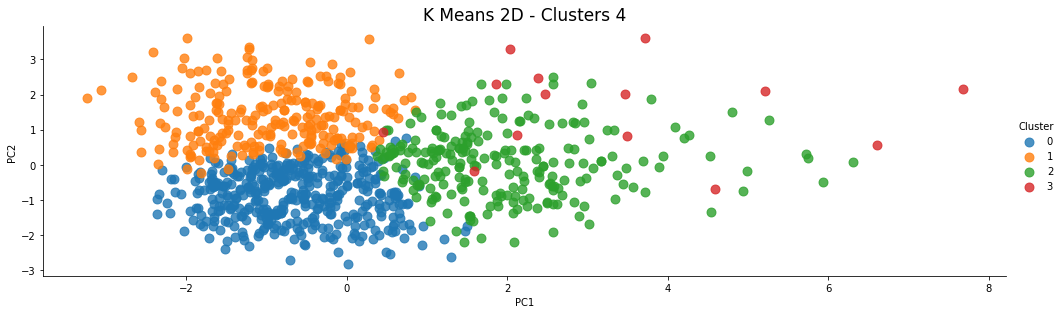

<Figure size 432x288 with 0 Axes>

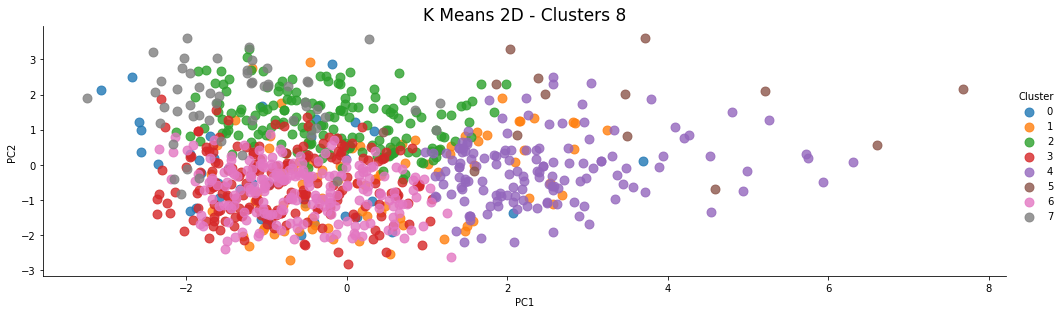

In [18]:
pca_2D = decomposition.PCA(n_components=2, random_state=42)
pca_3D = decomposition.PCA(n_components=3, random_state=42)

pc_2D = pca_2D.fit_transform(X_scaled)




'''
X_scaled_2D =
X_scaled_3D =

plot2D('K-Means with k = ', , )
plot3D('K-Means with k = ', , )
'''

df_pca_2D_k1 = pd.DataFrame(data=pc_2D, columns=['PC1', 'PC2'])
df_pca_2D_k1['Cluster'] = X_preds_k1

df_pca_2D_k2 = pd.DataFrame(data=pc_2D, columns=['PC1', 'PC2'])
df_pca_2D_k2['Cluster'] = X_preds_k2

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=df_pca_2D_k1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {}".format(k1_nclusters), fontsize=17)

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=df_pca_2D_k2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("K Means 2D - Clusters {}".format(k2_nclusters), fontsize=17)

<IPython.core.display.Javascript object>


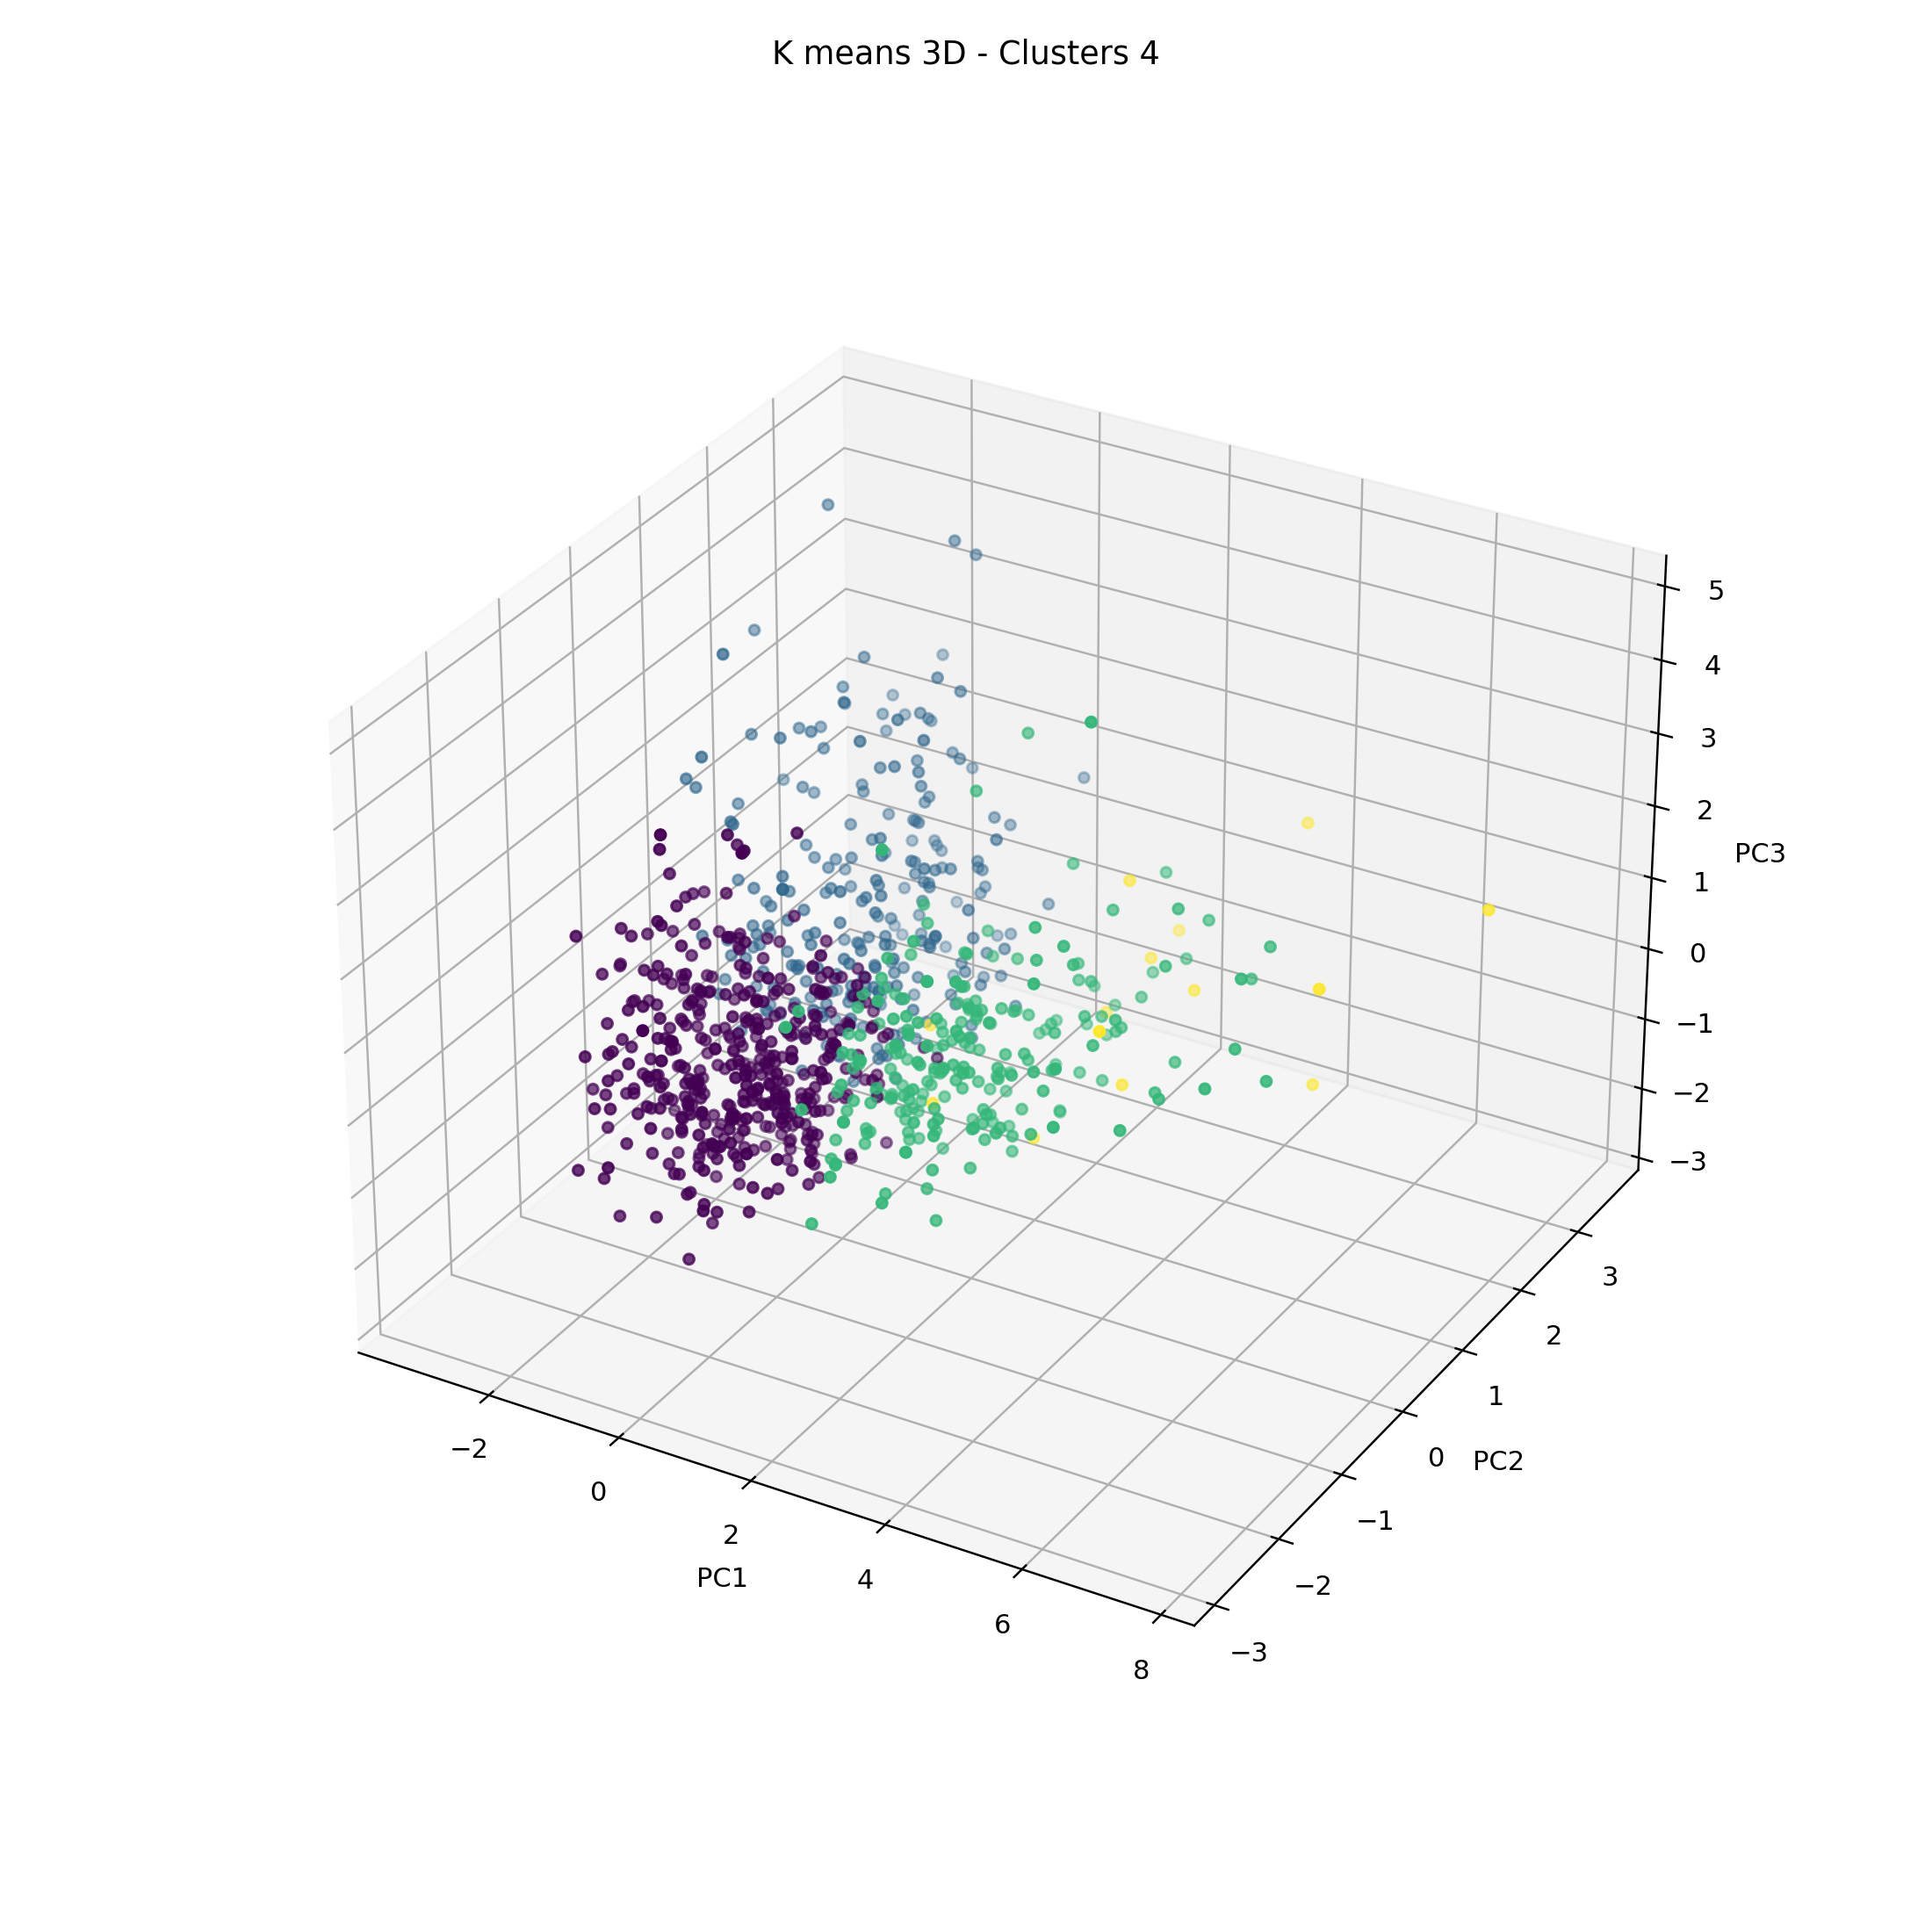

In [56]:
%matplotlib notebook

pca_3D = decomposition.PCA(n_components=3, random_state=42)

pc_3D = pca_3D.fit_transform(X_scaled)

df_pca_3D_k1 = pd.DataFrame(data=pc_3D, columns=['PC1', 'PC2', 'PC3'])
df_pca_3D_k1['Cluster'] = X_preds_k1

fig = plt.figure(figsize=(10,10))
fig.suptitle('K means 3D - Clusters {}'.format(k1_nclusters))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3D_k1['PC1'], df_pca_3D_k1['PC2'], df_pca_3D_k1['PC3'], c=df_pca_3D_k1['Cluster'], s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

<IPython.core.display.Javascript object>


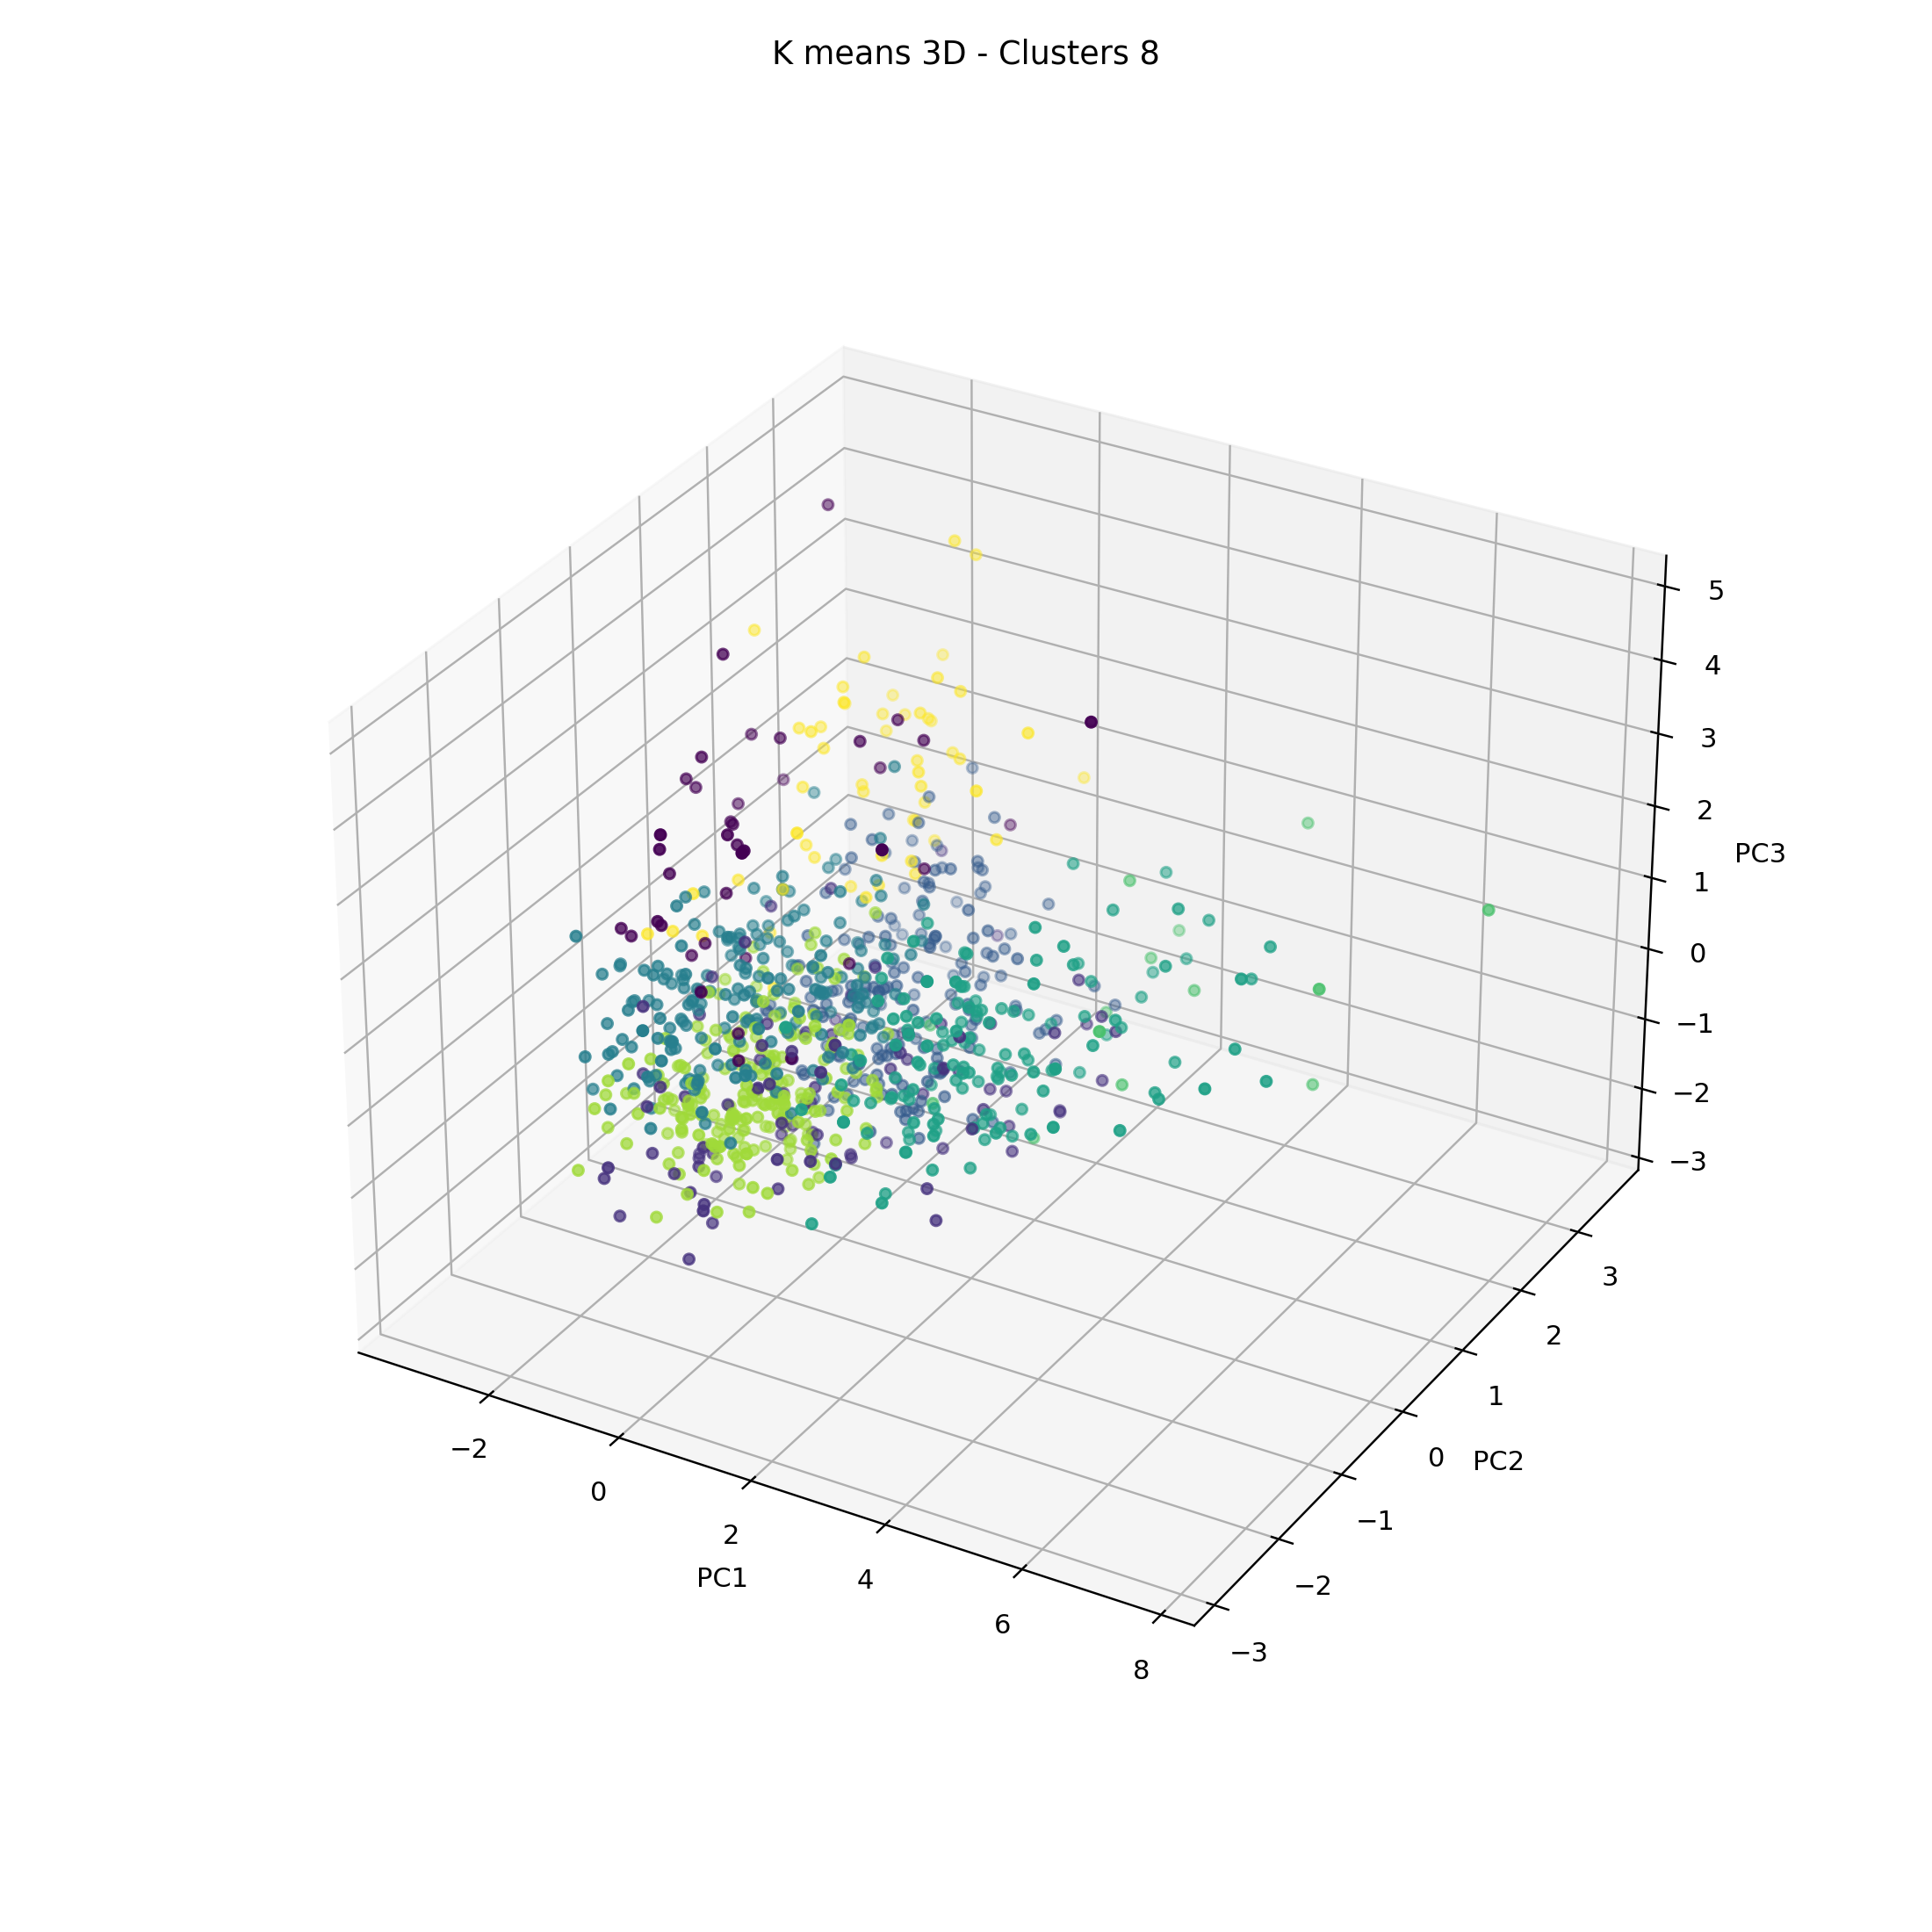

In [57]:
%matplotlib notebook

df_pca_3D_k2 = pd.DataFrame(data=pc_3D, columns=['PC1', 'PC2', 'PC3'])
df_pca_3D_k2['Cluster'] = X_preds_k2



fig = plt.figure(figsize=(10,10))
fig.suptitle('K means 3D - Clusters {}'.format(k2_nclusters))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3D_k2['PC1'], df_pca_3D_k2['PC2'], df_pca_3D_k2['PC3'], c=df_pca_3D_k2['Cluster'], s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### 5) Informe

Por último, deberán escribir un informe en el cual:
1. Muestren los clusters obtenidos en __3)__ como listas de canciones
2. Describan cualitativamente (e intuitivamente) estos clusters para cada __k__ elegido de acuerdo al contenido de los mismos, por ejemplo: 
    - El cluster 1 presenta canciones de géneros subsaharianos y es el más amplio debido a que..., el 2 de géneros tribales del cuerno de África, el 3...
    - Los clusters x0, x1, ... , xn no presentan algún patrón observable, pero xn+1 y xn+4 tienen...
4. Digan cuál k les dio resultados más coherentes y/o interpretables
5. Comparen los resultados obtenidos con aprendizaje no supervisado (con el mejor de los dos k) vs supervisado de manera cualitativa. Por ejemplo: nos parece mejor/peor/distinto/indistinto el modelo de aprendizaje no supervisado/supervisado en esta tarea porque...